In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
data_path = "data/data_complete.csv"

data = pd.read_csv(data_path, index_col=1, parse_dates=True)
data = data.iloc[:, 1:]

# scaler_x = MinMaxScaler(feature_range=(1, 2))
# scaler_y = MinMaxScaler(feature_range=(1, 2))
# scaled_data = scaler_x.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
# data["y"] = scaled_data
data["log_y"] = np.log(data["y"])


C:\Users\keipj\AppData\Local\Temp\ipykernel_16776\306710563.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(data_path, index_col=1, parse_dates=True)


In [42]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
column = "y"
Ntest = 29
train = data.iloc[:-Ntest]
test = data.iloc[-Ntest:]

def plot_fit_and_forecast_int(result, d, col="y"):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(data[col], label="data")

    train_pred = result.predict(start=train.index[d], end=train.index[-1])
    
    ax.plot(train.index[d:], train_pred, color="green", label="fitted")

    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f"lower {col}"], conf_int[f"upper {col}"]
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label="forecast")
    ax.fill_between(test.index, lower, upper, color="red", alpha=0.3)
    ax.legend()


def r2(result, is_logged):
    forecast = result.forecast(Ntest).to_numpy()
    if is_logged:
        forecast = np.exp(forecast)

    t = test["y"]
    y = forecast
    return r2_score(t, y)
# data[column].plot(figsize=(20, 8));


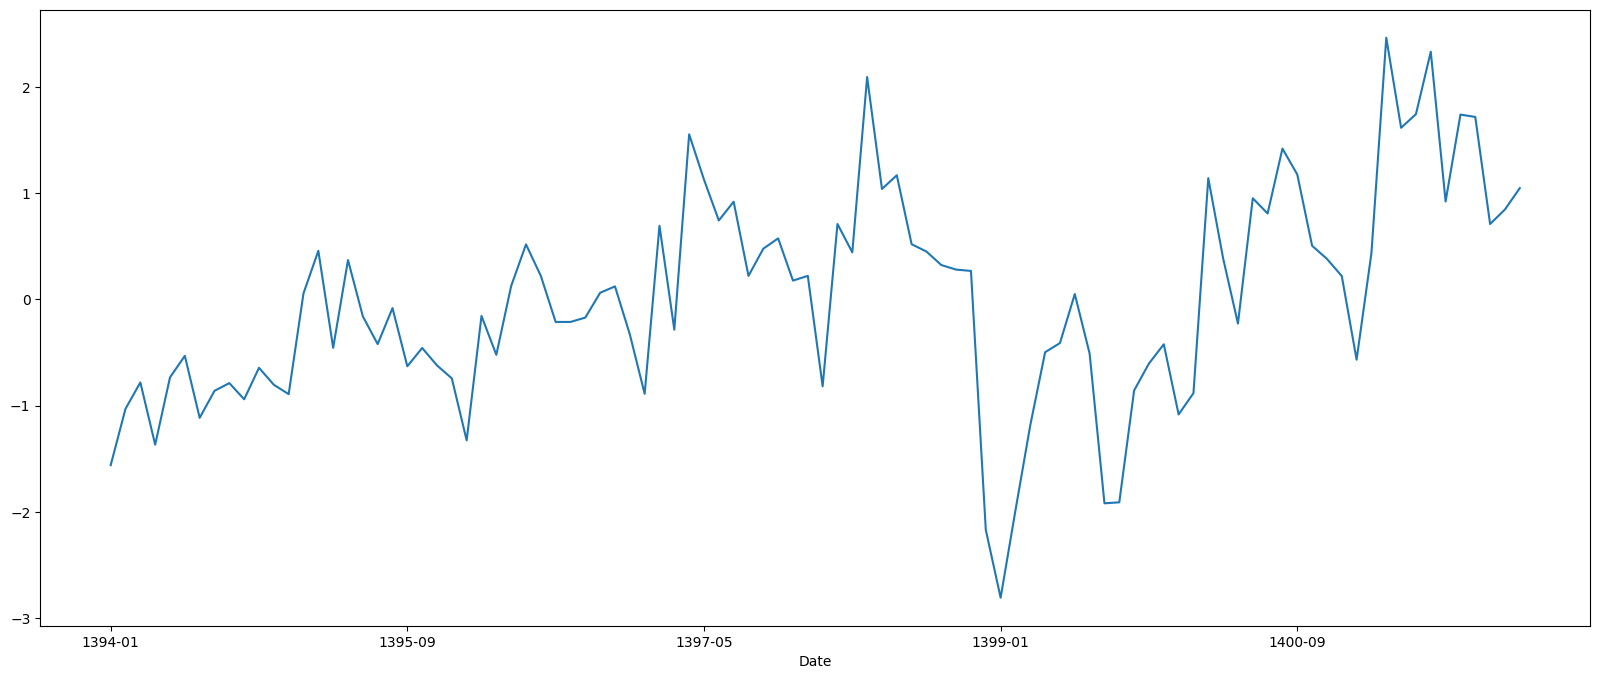

In [43]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method="box-cox")
data["new"] = scaler.fit_transform(np.array(data["y"]).reshape(-1, 1))
data["new"].plot(figsize=(20, 8));

In [44]:
import numpy as np
def f1(x):
    return np.log(np.log(x+1)+1)

def f2(x):
    return np.exp(np.exp(x)-1)-1

In [45]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
# scaler_xx = FunctionTransformer(func=f1, inverse_func=f2)
# scaler_yy = FunctionTransformer(func=f1, inverse_func=f2)
train[column] = scaler_x.fit_transform(np.array(train[column]).reshape(-1, 1))
test[column] = scaler_y.fit_transform(np.array(test[column]).reshape(-1, 1))
# train[column] = scaler_xx.fit_transform(np.array(train[column]).reshape(-1, 1))
# test[column] = scaler_yy.fit_transform(np.array(test[column]).reshape(-1, 1))


C:\Users\keipj\AppData\Local\Temp\ipykernel_16776\2482421461.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = scaler_x.fit_transform(np.array(train[column]).reshape(-1, 1))
C:\Users\keipj\AppData\Local\Temp\ipykernel_16776\2482421461.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[column] = scaler_y.fit_transform(np.array(test[column]).reshape(-1, 1))


## ARIMA

In [46]:
import pmdarima as pm

In [47]:
logmodel = pm.auto_arima(train[column],
                         trace=True,
                         suppress_warning=True, stepwise=True, m=6,
                         max_p=4, max_q=2, max_order=6)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=-83.825, Time=2.16 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=-46.892, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=-81.850, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=-66.616, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=130.193, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=-78.381, Time=0.44 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=-78.653, Time=0.48 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=-96.213, Time=0.49 sec
 ARIMA(2,0,2)(2,0,0)[6] intercept   : AIC=-83.279, Time=0.42 sec
 ARIMA(2,0,2)(2,0,2)[6] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=-90.347, Time=0.51 sec
 ARIMA(1,0,2)(2,0,1)[6] intercept   : AIC=-98.205, Time=0.40 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=-85.776, Time=0.32 sec
 ARIMA(1,0,2)(2,0,0)[6] intercept   : AIC=-94.716, Time=0.44 sec
 ARIMA(1,0,2)(2,0,2)[6] intercept   : AIC=inf, Time

In [48]:
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   67
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 6)   Log Likelihood                  55.194
Date:                           Mon, 03 Jun 2024   AIC                           -100.388
Time:                                   18:44:12   BIC                            -89.365
Sample:                                        0   HQIC                           -96.026
                                            - 67                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0466      0.030      1.531      0.126      -0.013       0.106
ar.L1          0.7334      0.085      8.676      0.000       0.568       0.899
ar.S.L6        0.0242      0.166      0.146      0.884      -0.301       0.349
ar.S.L12       0.6487      0.116      5.589      0.000       0.421       0.876
sigma2         0.0100      0.001     10.067      0.000       0.008       0.012
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               197.20
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               4.16   Skew:                            -1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


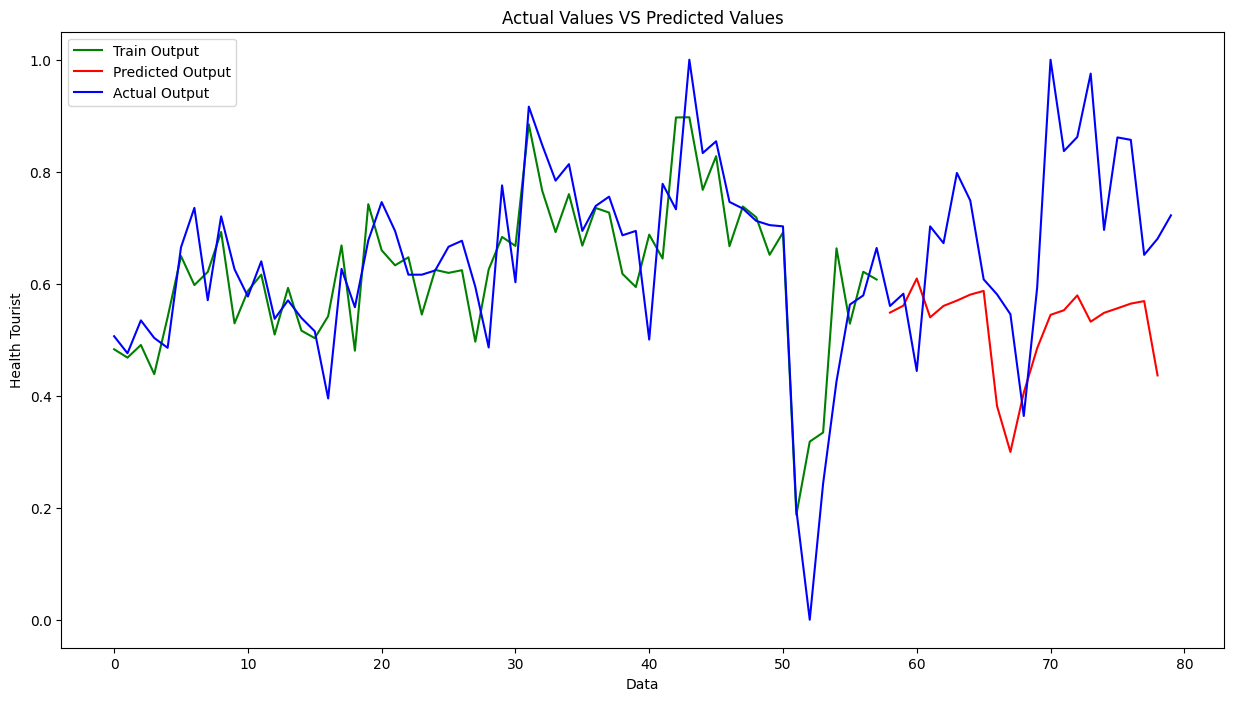

In [53]:
test_pred = logmodel.predict(n_periods=Ntest)[8:]
# test_pred = scaler_yy.inverse_transform(np.array(test_pred).reshape(-1, 1))
# test_pred = scaler_y.inverse_transform(np.array(test_pred).reshape(-1, 1))
train_pred = logmodel.predict_in_sample(start=1, end=-1)[8:]
# train_pred = scaler_xx.inverse_transform(np.array(train_pred).reshape(-1, 1))
# train_pred = scaler_x.inverse_transform(np.array(train_pred).reshape(-1, 1))
fig, ax = plt.subplots(figsize=(15, 8))
acc = train[column][8:].values
acc2 = test[column][8:].values
acc = np.append(acc, acc2)
ax.plot(range(len(train_pred)), train_pred, label="Train Output", c="green")
ax.plot(range(len(train_pred),len(train_pred)+len(test_pred)), test_pred, label="Predicted Output", c="red")
ax.plot(range(len(acc)), acc, label="Actual Output", c="blue")
# plt.xticks(ticks=, rotation=45)
plt.xlabel("Data")
plt.ylabel("Health Tourist")
plt.title("Actual Values VS Predicted Values")
ax.legend()
plt.savefig("output.png")

In [55]:
def mse(t, y):
    return np.mean((t-y)**2)

print("MSE test:", mse(test[column][8:].values, test_pred))
print("MSE train:", mse(train[column][9:].values, train_pred))

MSE test: 0.05319027466495186
MSE train: 0.011113115676406136


In [56]:
test_pred = logmodel.predict(Ntest+12)
test_pred = scaler_y.inverse_transform(np.array(test_pred).reshape(-1, 1))
test_pred[-12:]

c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


array([[2364.98607739],
       [2540.39829537],
       [2671.13784919],
       [2769.83453917],
       [2783.70303985],
       [2819.16700756],
       [2738.60252955],
       [2768.8462563 ],
       [2785.31858518],
       [2801.50444245],
       [2809.22386605],
       [2591.6568748 ]])